В этом ноутбуке будут приведены мои наработки по заданию на класстеризацию разреженных данных. 

За 50 с лишним попыток было исследовано много методов, но из-за длительного выполнения некоторых, они не будут запущены, но я постараюсь дать комментарии к ним. 

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import mode
import matplotlib.pyplot as plt
import gc

In [3]:
sparse_matrix = sparse.load_npz('train.npz')

In [4]:
sparse_matrix.shape

(14590, 77888)

In [8]:
print("Mean value:", sparse_matrix.mean())
print("Median value:", np.median(sparse_matrix.data))
print("Minimum value:", sparse_matrix.min())
print("Maximum value:", sparse_matrix.max())

Mean Value: 0.00013130341339263378
Median Value: 0.06191956034922004
Minimum Value: 0.0
Maximum Value: 0.7475549463482876


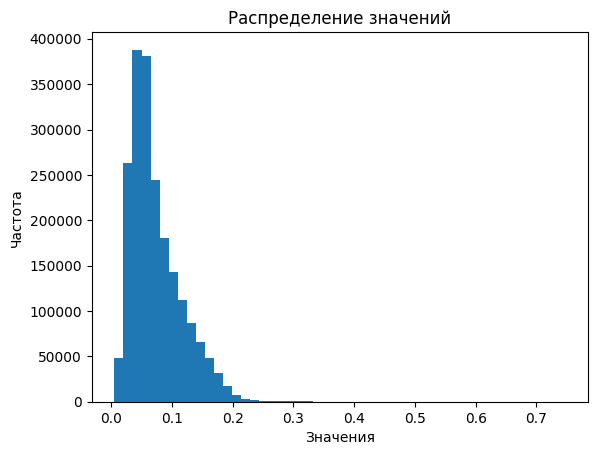

In [4]:
plt.hist(sparse_matrix.data, bins=50)
plt.title('Распределение значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [5]:
density = ((sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))) * 100
print("Плотность данных:", density, "%")

Плотность данных: 0.17835217458519725 %


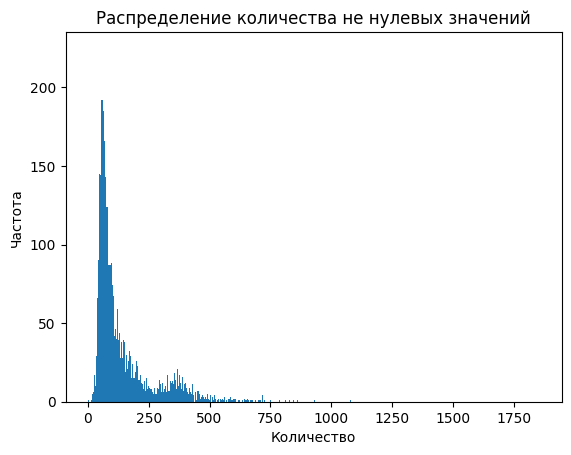

In [3]:
nonzero_values_distribution = sparse_matrix.getnnz(axis=1)

# Визуализация распределения не нулевых значений по строкам
plt.hist(nonzero_values_distribution, bins=np.arange(min(nonzero_values_distribution), max(nonzero_values_distribution) + 1) - 0.5)
plt.title('Распределение количества не нулевых значений')
plt.xlabel('Количество')
plt.ylabel('Частота')
plt.show()

In [5]:
median_nonzero_values = np.median(nonzero_values_distribution)

print("Медианное количество:", median_nonzero_values)
mode_nonzero_values, _ = mode(nonzero_values_distribution)

print("Мода:", mode_nonzero_values)

Медианное количество: 87.0
Мода: 61


Как мы видим у нас довольно неплохое среднее и самое популярное количество непустых фич, с которыми в теории можно было бы работать. Поэтому одной из идей было уменьшение их размерности и последующая класстеризация сжатых данных.

Пробовал:
1.TruncatedSVD
2.faiss.PCAMatric
3.Autoencoder

### SVD

In [5]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
compressed_matrix = svd.fit_transform(sparse_matrix)

# Оцениваем долю сохранненой дисперсии
explained_variance_ratio = svd.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

print("Доля сохранненой дисперсии по компанентам:", explained_variance_ratio)
print("Общая:", total_explained_variance)

Доля сохранненой дисперсии по компанентам: [0.00205074 0.00213016 0.00169254 0.00138741 0.00119459 0.00113664
 0.00109389 0.00101936 0.00097384 0.00093549 0.00092673 0.00088719
 0.0008629  0.00086129 0.00084393 0.00082781 0.00080851 0.00079795
 0.00077745 0.00075849 0.00075275 0.00073299 0.00072469 0.00071699
 0.0007046  0.00069421 0.00068494 0.00067011 0.00065979 0.00064368
 0.00064116 0.00063313 0.00063058 0.0006249  0.00061741 0.0006098
 0.00060574 0.00060421 0.00059797 0.00058831 0.00058281 0.00058079
 0.00057932 0.00056766 0.00056062 0.00055909 0.00055495 0.00055144
 0.00054866 0.00054306 0.00053722 0.00053264 0.00053131 0.00052366
 0.00052157 0.00051998 0.00051609 0.00051373 0.00051084 0.00050663
 0.00050218 0.00050039 0.00049858 0.00049687 0.000491   0.00048528
 0.00048271 0.00048141 0.00047661 0.00047508 0.00047441 0.00046923
 0.00046804 0.000464   0.00046267 0.00045492 0.00045421 0.00045121
 0.00044825 0.00044648 0.00044246 0.00044024 0.00043686 0.0004342
 0.00042879 0.0004266

Как мы видим очень низкая и скор на таких данных показывал так же не лудшие значения

### PCAMatrix

In [ ]:
import faiss
x = np.float32(sparse_matrix.toarray())
mat = faiss.PCAMatrix(77888, 100)
mat.train(x)
#Получаем сжатые данные
tr = mat.apply(x)

In [10]:
torch.cuda.empty_cache()
gc.collect()

1628

### Autoencoder

In [ ]:
import torch
import torch.nn as nn
from torch_optimizer import Ranger
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(77888, 2048, dtype=torch.float64),
            nn.ELU(),
            nn.Linear(2048, 512, dtype=torch.float64),
            nn.ELU(),
            nn.Linear(512, 256, dtype=torch.float64),
            nn.ELU(),
            nn.Linear(256, 128, dtype=torch.float64),
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512, dtype=torch.float64),
            nn.ELU(),
            nn.Linear(512, 2048, dtype=torch.float64),
            nn.ELU(),
            nn.Linear(2048, 77888, dtype=torch.float64),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def pairwise_mse_loss(input_matrix, output_matrix):
    mse_loss = torch.nn.MSELoss()
    input_vector = input_matrix.view(-1)
    output_vector = output_matrix.view(-1)
    mse = mse_loss(input_vector, output_vector)
    return mse

original_vectors = torch.tensor(sparse_matrix.toarray(), dtype=torch.float64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем модель и отправляем на GPU, если доступно
input_dim = 77888
encoding_dim = 100
autoencoder = Autoencoder(input_dim, encoding_dim).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()

def frobenius_norm(input_matrix, output_matrix):
    return torch.norm(input_matrix - output_matrix, 'fro')

optimizer = Ranger(autoencoder.parameters(), lr=1e-3, alpha=0.5, k=6, N_sma_threshhold=5, betas=(.95, 0.999), eps=1e-5, weight_decay=0)

# Создаем DataLoader для удобства работы с данными
dataset = TensorDataset(original_vectors)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

autoencoder.train()
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    total_frobenius_norm = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    
    for data in pbar:
        inputs, = data
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs, encoded = autoencoder(inputs)
        
        loss = criterion(outputs, inputs)
            
        
        #frobenius_loss = pairwise_mse_loss(inputs.mm(inputs.t()), encoded.mm(encoded.t()))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.update(1)
        pbar.set_postfix({"Loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.8f}")

In [ ]:
# Инференс сжатых
new_batch_size = 1000
original_vectors = original_vectors.to(device)

compressed_vectors_list = []
with torch.no_grad():
    autoencoder.eval()
    for i in range(0, len(original_vectors), new_batch_size):
        batch = original_vectors[i:i+new_batch_size]
        compressed_vectors_batch = autoencoder.encoder(batch).cpu().numpy()
        compressed_vectors_list.extend(compressed_vectors_batch)

Процент сохранненой дисперсии был хоть и выше в 3 раза и составлял 18% но скор все равно был плохой

TSNE и UMAP, давали также отрицательный скор

## Испробовал всевозможные классические алгоритмы, которые смогли запуститься на разреженных данных или хотя бы не вылетели из-за переполнения памяти

Первый неплохой результат показал Kmeans (~0.03), но необходимо было нормализовать данные RobustScaler

In [7]:
df = pd.read_csv('submission.csv')

In [5]:
%%time
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
data = RobustScaler().fit_transform(sparse_matrix.toarray())
labels = KMeans(n_clusters=3, random_state=42, init="k-means++",algorithm='full').fit_predict(data)

Wall time: 11min 47s


In [8]:
df['TARGET'] = labels

In [9]:
df['TARGET'].value_counts()

1    9130
0    2919
2    2541
Name: TARGET, dtype: int64

MiniBatchKMeans показал результат чуть лучше, но существенного прироста не было

In [ ]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=3, random_state=0, init='k-means++')
labels = kmeans.fit_predict(sparse_matrix.toarray())

Пробовал запускать AffinityPropagation, который вроде как должен хорошо работать с разреженными данными, нужного количества кластеров спустя долгое время тренировок он достигает при preference=-50. Но результат, к сожалению, был даже меньше 0.

In [ ]:
affinity_propagation = AffinityPropagation(preference=-50)
labels = affinity_propagation.fit_predict(sparse_matrix)

Пробовал hdbscan.HDBSCAN

In [ ]:
import hdbscan
labels = hdbscan.HDBSCAN(min_cluster_size=1000, p=None).fit_predict(sparse_matrix.toarray())

Birch, BisectingKMeans

In [ ]:
from sklearn.cluster import BisectingKMeans, Birch
labels = Birch(n_clusters=3).fit_predict(sparse_matrix.toarray())

Но все они либо совсем не давали какого-то хорошо результата либо улучшали совсем ничего

Пробовал бинаризировать данные и использовать другие метрики, и все это не было лучше просто KMeans

In [10]:
binary_matrix = sparse_matrix.copy()
binary_matrix.data = (binary_matrix.data != 0).astype(int)

In [ ]:
from sklearn.cluster import OPTICS
labels = OPTICS(min_samples = 1000, metric='jaccard', n_jobs = -1).fit_predict(binary_train.toarray())

Mean Shift, Gaussian Mixture, Agglomerative clustering завести не удалось из-за переполнения памяти, но думаю они бы не показали хорошего результата

Единственный алгоритм, который у меня заработал был SpectralClustering

Это самый быстрый вариант, который у меня отработал и дал скор ~0.10

In [15]:
%%time
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=3,
         random_state=0, assign_labels="discretize", n_jobs=-1).fit_predict(sparse_matrix)

Wall time: 27.7 s


In [16]:
df['TARGET'] = labels

In [17]:
df['TARGET'].value_counts()

2    6309
0    5050
1    3231
Name: TARGET, dtype: int64

Дальше я эксперементировал со значениями, и было подозрение, что количество семплов в кластерах должно быть равномерно, потому что с увеличением n_neighbors, скор увеличивался. Но обучить для равновероятного распределения мне не удалось, из-за незватки памяти. Также лучший результат был достигнут при n_neighbors=3500 ~0.11. Обучалось чуть больше 20 минут. Нормализация данных раздичными способами (Standard Scaler, Min Max Scaler, Robust Scaler) 

In [ ]:
%%time
labels = SpectralClustering(n_clusters=3,
         random_state=0, n_neighbors=3500, 
         affinity="nearest_neighbors", assign_labels="discretize", n_jobs=-1).fit_predict(sparse_matrix)

## Выводы
К сожалению, немного не удалось достичь little_complicated. 
Были испробованы многие методы, что в целом помогло получше углубиться в тему. Но мне не хватило понимания природы данных. 
Думал может быть это векторизованные данные текстов или что-то типо данных user-item, но бинаризация и SVD не дали никаких результатов. Поэтому в некоторых ситуациях решение сводилось к перебору различных методов и подбору гиперпараметров, что не очень продуктивно было. 


P.S. Спасибо за задание, надеюсь будет разбор для этого задания с рассмотрение методик, алгоритмов и подходов к решени.